# Frailty Classifier:  Summary stats

This notebook provides an overview of the datasets comprising the frailty classifier project.  It's intended to be a living document -- things can be added and altered as needed.

This notebook provides basic summary stats on the data for the frailty classifier project.  It'll start with data on the population, and move into data on the notes.

Begin with imports and preliminaries:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import re
import geopandas as gpd
import os

datadir = "/Users/crandrew/projects/GW_PAIR_frailty_classifier/data/"
figdir = "/Users/crandrew/projects/GW_PAIR_frailty_classifier/figures/"
gisdir = "/Users/crandrew/shapefiles/"

# preferences
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

# load "znotes" -- the notes metadata
znotes = pd.read_csv(f"{datadir}notes_metadata_2018.csv")
znotes['ENTRY_TIME'] = pd.to_datetime(znotes['ENTRY_TIME'])
znotes = znotes[znotes['ENTRY_TIME'].dt.year >= 2018]

The data frame `znotes` contains information on CSN's that have associated notes, but not the actual note.  That's stored elsewhere, and will be explored below.  I'll go through the relevant columns of `znotes` and plot or tabulate relevant summary stats.

In [10]:
znotes.columns

Index(['Unnamed: 0', 'PAT_ENC_CSN_ID', 'NOTE_SERIAL_NUM', 'IP_NOTE_TYPE',
       'NOTE_ENTRY_TIME', 'NOTE_ID', 'CONTACT_NUM', 'MRN', 'PAT_ID',
       'EFFECTIVE_DATE_DTTM', 'ENTRY_TIME', 'AGE', 'ADMSN_TYPE',
       'PATIENT_CLASS', 'UNIT', 'DEPARTMENT_NAME', 'EXTERNAL_NAME',
       'SPECIALTY', 'LOCATION_ABBR', 'SEX', 'MARITAL_STATUS', 'RELIGION',
       'EMPY_STAT', 'RACE', 'ETHNICITY', 'LANGUAGE', 'COUNTY', 'ZIP',
       'ENCOUNTER_TYPE', 'dxcount', 'dxvec', 'highprob', 'lowprob'],
      dtype='object')

In [13]:
# note types...
znotes.IP_NOTE_TYPE.unique()

array(['Progress Notes'], dtype=object)

They are all progress notes.  Entry time has been covered elsewhere, as has age.  Let's look at admission type:

In [17]:
print(znotes.ADMSN_TYPE.value_counts())
print(znotes.shape)

Routine Elective Admission    38139
Name: ADMSN_TYPE, dtype: int64
(73366, 33)


So, they're all either routine elective admissions, or null.

In [19]:
print(znotes.PATIENT_CLASS.value_counts())

MAPS           37785
Outpatient       388
Emergency          1
Day Surgery        1
Name: PATIENT_CLASS, dtype: int64


Mostly "MAPS", or Null (recall that there are 73K notes).  No idea what "MAPS" is.  I've asked the DS folks and they don't either.  Let's look at its overlap with a few factors related to the encounter:

In [25]:
znotes[znotes.PATIENT_CLASS == "MAPS"][['ADMSN_TYPE', "SPECIALTY", "LOCATION_ABBR", "ENCOUNTER_TYPE"]].describe()


,ADMSN_TYPE,SPECIALTY,LOCATION_ABBR,ENCOUNTER_TYPE
count,37783,37785,37785,37785
unique,1,4,8,2
top,Routine Elective Admission,Pulmonary,PCAM,Office Visit
freq,37783,21873,14643,37692


In [24]:
znotes[znotes.PATIENT_CLASS != "MAPS"][['ADMSN_TYPE', "SPECIALTY", "LOCATION_ABBR", "ENCOUNTER_TYPE"]].describe()


,ADMSN_TYPE,SPECIALTY,LOCATION_ABBR,ENCOUNTER_TYPE
count,356,35581,35581,35581
unique,1,4,55,2
top,Routine Elective Admission,Internal Medicine,PMWSW,Office Visit
freq,356,21142,3610,35430


In [26]:
znotes[znotes.PATIENT_CLASS == "MAPS"].SPECIALTY.value_counts()

Pulmonary            21873
Internal Medicine    10285
Family Practice       4294
Gerontology           1333
Name: SPECIALTY, dtype: int64

In [27]:
znotes[znotes.PATIENT_CLASS != "MAPS"].SPECIALTY.value_counts()

Internal Medicine    21142
Family Practice       9094
Pulmonary             4877
Gerontology            468
Name: SPECIALTY, dtype: int64

In [28]:
znotes[znotes.PATIENT_CLASS == "MAPS"].ENCOUNTER_TYPE.value_counts()

Office Visit    37692
Appointment        93
Name: ENCOUNTER_TYPE, dtype: int64

In [29]:
znotes[znotes.PATIENT_CLASS != "MAPS"].ENCOUNTER_TYPE.value_counts()

Office Visit    35430
Appointment       151
Name: ENCOUNTER_TYPE, dtype: int64

We've learned that the "MAPS" category is associated with Pulmonary office visits, at fewer locations, and non-MAPS are IM office visits at more locations.  The "Routine Elective Admission" type is all MAPS.

(array([3.0066e+04, 2.4340e+04, 1.1508e+04, 4.7910e+03, 1.7440e+03,
        6.1500e+02, 2.1400e+02, 6.0000e+01, 1.0000e+01, 1.8000e+01]),
 array([  0. ,  26.8,  53.6,  80.4, 107.2, 134. , 160.8, 187.6, 214.4,
        241.2, 268. ]),
 <a list of 10 Patch objects>)

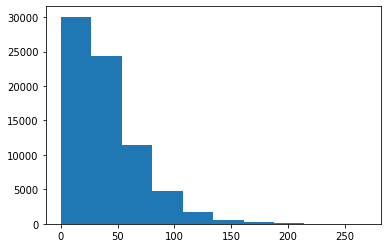

In [30]:
plt.hist(znotes.dxcount)